In [10]:
from jmetal.algorithm.multiobjective import RandomSearch, NSGAII, SPEA2, MOEAD
from jmetal.operator.crossover import SBXCrossover, DifferentialEvolutionCrossover
from jmetal.operator.mutation import PolynomialMutation
from jmetal.problem.multiobjective.dtlz import DTLZ2, DTLZ7
from jmetal.util.aggregation_function import PenaltyBoundaryIntersection
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.solution import get_non_dominated_solutions, print_function_values_to_file
from jmetal.core.quality_indicator import HyperVolume,NormalizedHyperVolume, InvertedGenerationalDistance
import numpy as np
import matplotlib.pyplot as plt

def execute_analysis(problem, algorithm_max_evaluations):
    problem_name = problem.name() 
    ref_front = np.loadtxt(f"resources/reference_fronts/{problem_name}.pf")
    pop_size = 100
    off_size = 100
    cro = 0.7
    mut = 0.5
    
    rnd = RandomSearch(
        problem=problem,
        termination_criterion=StoppingByEvaluations(max_evaluations=algorithm_max_evaluations)
    )
    
    nsgaII = NSGAII(
            problem=problem,
            population_size=pop_size,
            offspring_population_size=off_size,
            mutation=PolynomialMutation(mut, distribution_index=20),
            crossover=SBXCrossover(probability=cro, distribution_index=20),
            termination_criterion=StoppingByEvaluations(max_evaluations=algorithm_max_evaluations))

    spea2 = SPEA2(
            problem=problem,
            population_size=pop_size,
            offspring_population_size=off_size,
            mutation=PolynomialMutation(mut, distribution_index=20),
            crossover=SBXCrossover(probability=cro, distribution_index=20),
            termination_criterion=StoppingByEvaluations(max_evaluations=algorithm_max_evaluations))
    
    moead = MOEAD(
            problem=problem,
            population_size=pop_size,
            crossover=DifferentialEvolutionCrossover(CR=1.0, F=0.5),
            mutation=PolynomialMutation(mut, distribution_index=20),
            aggregation_function=PenaltyBoundaryIntersection(dimension=problem.number_of_objectives()),
            neighbor_size=20,
            neighbourhood_selection_probability=0.9,
            max_number_of_replaced_solutions=2,
            weight_files_path="resources/MOEAD_weights",
            termination_criterion=StoppingByEvaluations(max_evaluations=algorithm_max_evaluations))
    
    algorithms = [rnd, nsgaII, spea2, moead]
    
    for algorithm in algorithms:
        algorithm.run()
        front = get_non_dominated_solutions(algorithm.result())
        filepath = f'results/comparative_analysis/FUN.{algorithm.get_name()}.{problem_name}'
        print_function_values_to_file(front, filepath)
        
        aprx_front = np.loadtxt(filepath)
        
        hv_ref_point = np.max(ref_front, axis=0) + 0.1
        nhv = NormalizedHyperVolume(hv_ref_point, ref_front)
        hv = HyperVolume(hv_ref_point)
        igd = InvertedGenerationalDistance(ref_front)
        print(f'{algorithm.get_name()}, {problem_name}, HV = {hv.compute(aprx_front.reshape(-1, problem.number_of_objectives()))}, nHV = {nhv.compute(aprx_front.reshape(-1, problem.number_of_objectives()))}, IGD = {igd.compute(aprx_front.reshape(-1, problem.number_of_objectives()))}')
            


In [26]:
def generate_plots_3d(problem_name):
    ref_front = np.loadtxt(f"resources/reference_fronts/{problem_name}.pf")
    ref_x = ref_front[:, 0]
    ref_y = ref_front[:, 1]
    ref_z = ref_front[:, 2]
    
    hv_ref_point = np.max(ref_front, axis=0) + 0.1
    hv = HyperVolume(hv_ref_point)
    nhv = NormalizedHyperVolume(hv_ref_point, ref_front)
    igd = InvertedGenerationalDistance(ref_front)

    fun1 = np.loadtxt(f"results/comparative_analysis/FUN.Random Search.{problem_name}").reshape(-1, 3)
    fun1_x = fun1[:, 0]
    fun1_y = fun1[:, 1]
    fun1_z = fun1[:, 2]
    fun1_hv = hv.compute(fun1)
    fun1_nhv = nhv.compute(fun1)
    fun1_igd = igd.compute(fun1)

    fun2 = np.loadtxt(f"results/comparative_analysis/FUN.NSGAII.{problem_name}").reshape(-1, 3)
    fun2_x = fun2[:, 0]
    fun2_y = fun2[:, 1]
    fun2_z = fun2[:, 2]
    fun2_hv = hv.compute(fun2)
    fun2_nhv = nhv.compute(fun2)
    fun2_igd = igd.compute(fun2)
 
    fun3 = np.loadtxt(f"results/comparative_analysis/FUN.SPEA2.{problem_name}").reshape(-1, 3)
    fun3_x = fun3[:, 0]
    fun3_y = fun3[:, 1]
    fun3_z = fun3[:, 2]
    fun3_hv = hv.compute(fun3)
    fun3_nhv = nhv.compute(fun3)
    fun3_igd = igd.compute(fun3)
 
    fun4 = np.loadtxt(f"results/comparative_analysis/FUN.MOEAD.{problem_name}").reshape(-1, 3)
    fun4_x = fun4[:, 0]
    fun4_y = fun4[:, 1]
    fun4_z = fun4[:, 2]
    fun4_hv = hv.compute(fun4)
    fun4_nhv = nhv.compute(fun4)
    fun4_igd = igd.compute(fun4)
    
    fig = plt.figure(figsize=(12, 10))
    elev = 30
    azim = 45
    roll = 0
    ndigits = 4
    fontsize = 12
    zoom = 0.9
    ax = fig.add_subplot(221, projection='3d')
    ax.scatter3D(ref_x, ref_y, ref_z)
    ax.scatter3D(fun1_x, fun1_y, fun1_z)
    ax.set_box_aspect(None, zoom=zoom)
    ax.set_xlabel('$f_1{(x)}$')
    ax.set_ylabel('$f_2{(x)}$')
    ax.set_zlabel('$f_3{(x)}$')
    ax.view_init(elev, azim, roll)
    ax.set_title(f'a) Random Search (nHV = {round(fun1_nhv, ndigits)}, IGD = {round(fun1_igd, ndigits)})', fontsize=fontsize)
    
    ax = fig.add_subplot(222, projection='3d')
    ax.scatter3D(ref_x, ref_y, ref_z)
    ax.scatter3D(fun2_x, fun2_y, fun2_z)
    ax.set_box_aspect(None, zoom=zoom)
    ax.set_xlabel('$f_1{(x)}$')
    ax.set_ylabel('$f_2{(x)}$')
    ax.set_zlabel('$f_3{(x)}$')
    ax.view_init(elev, azim, roll)
    ax.set_title(f'b) NSGAII (nHV = {round(fun2_nhv, ndigits)}, IGD = {round(fun2_igd, ndigits)})', fontsize=fontsize)

    ax = fig.add_subplot(223, projection='3d')
    ax.scatter3D(ref_x, ref_y, ref_z)
    ax.scatter3D(fun3_x, fun3_y, fun3_z)
    ax.set_box_aspect(None, zoom=zoom)
    ax.set_xlabel('$f_1{(x)}$')
    ax.set_ylabel('$f_2{(x)}$')
    ax.set_zlabel('$f_3{(x)}$')
    ax.view_init(elev, azim, roll)
    ax.set_title(f'c) SPEA2 (nHV = {round(fun3_nhv, ndigits)}, IGD = {round(fun3_igd, ndigits)})', fontsize=fontsize)

    ax = fig.add_subplot(224, projection='3d')
    ax.scatter3D(ref_x, ref_y, ref_z)
    ax.scatter3D(fun4_x, fun4_y, fun4_z)
    ax.set_box_aspect(None, zoom=zoom)
    ax.set_xlabel('$f_1{(x)}$')
    ax.set_ylabel('$f_2{(x)}$')
    ax.set_zlabel('$f_3{(x)}$')
    ax.view_init(elev, azim, roll)
    ax.set_title(f'd) MOEAD (nHV = {round(fun4_nhv, ndigits)}, IGD = {round(fun4_igd, ndigits)})', fontsize=fontsize)

    fig.savefig(f'img/{problem_name}_results.png')
    plt.show()

In [19]:
algorithm_max_evaluations = 100000

In [20]:
problem = DTLZ2()

In [21]:
execute_analysis(problem, algorithm_max_evaluations)

[2025-10-21 11:10:19,626] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-21 11:10:19,628] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-21 11:10:19,632] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-21 11:10:19,634] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2025-10-21 11:10:25,080] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-21 11:10:25,137] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.DTLZ2
[2025-10-21 11:10:58,997] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-21 11:10:58,999] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-21 11:10:59,002] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-21 11:10:59,004] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, DTLZ2, HV = 0.3863050462943875, nHV = 0.5154640483791777, IGD = 0.18403970484685978


[2025-10-21 11:11:21,979] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-21 11:11:21,983] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.DTLZ2
[2025-10-21 11:11:56,587] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-21 11:11:56,590] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-21 11:11:56,592] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-21 11:11:56,594] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, DTLZ2, HV = 0.6514472764834315, nHV = 0.18290058835744916, IGD = 0.08384463819205552


[2025-10-21 12:48:31,815] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-21 12:48:31,819] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.DTLZ2
[2025-10-21 12:49:09,263] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-21 12:49:09,265] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-21 12:49:09,267] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-21 12:49:09,269] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, DTLZ2, HV = 0.6598483326970265, nHV = 0.17236328420850933, IGD = 0.07506863921442088


[2025-10-21 12:49:51,336] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-21 12:49:51,344] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.DTLZ2


MOEAD, DTLZ2, HV = 0.6822343302543097, nHV = 0.14428490228353252, IGD = 0.07605595276521845


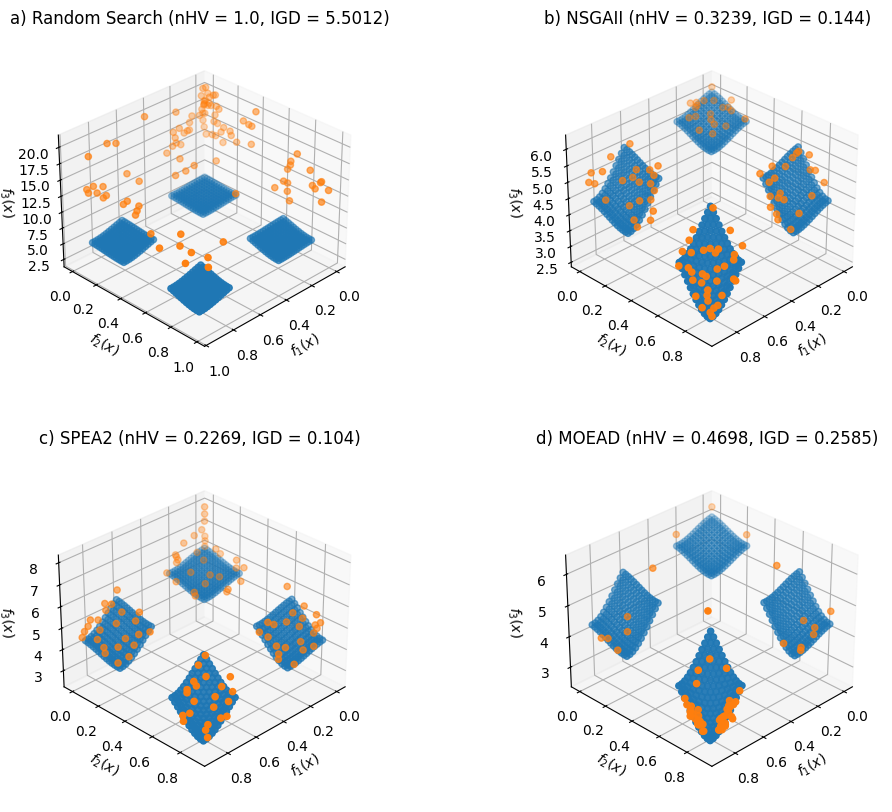

In [27]:
generate_plots_3d(problem.name())

In [23]:
problem = DTLZ7()

In [24]:
execute_analysis(problem, algorithm_max_evaluations)

[2025-10-21 12:51:07,009] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-21 12:51:07,010] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-21 12:51:07,012] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-21 12:51:07,015] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2025-10-21 12:51:09,316] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-21 12:51:09,321] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.DTLZ7
[2025-10-21 12:51:09,408] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-21 12:51:09,410] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-21 12:51:09,412] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-21 12:51:09,414] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, DTLZ7, HV = 0.0, nHV = 1.0, IGD = 5.501176477831414


[2025-10-21 12:51:35,529] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-21 12:51:35,534] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.DTLZ7
[2025-10-21 12:51:35,639] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-21 12:51:35,641] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-21 12:51:35,643] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-21 12:51:35,644] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, DTLZ7, HV = 0.8980914078510427, nHV = 0.3238908558250172, IGD = 0.14404332998212427


[2025-10-21 13:37:10,154] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-21 13:37:10,165] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.DTLZ7
[2025-10-21 13:37:10,323] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-21 13:37:10,327] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-21 13:37:10,331] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-21 13:37:10,333] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, DTLZ7, HV = 1.0269633892659338, nHV = 0.22687230704383576, IGD = 0.10400740850979923


[2025-10-21 13:38:20,992] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-21 13:38:21,005] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.DTLZ7


MOEAD, DTLZ7, HV = 0.7042844377742645, nHV = 0.4697943390654341, IGD = 0.25852935169836405


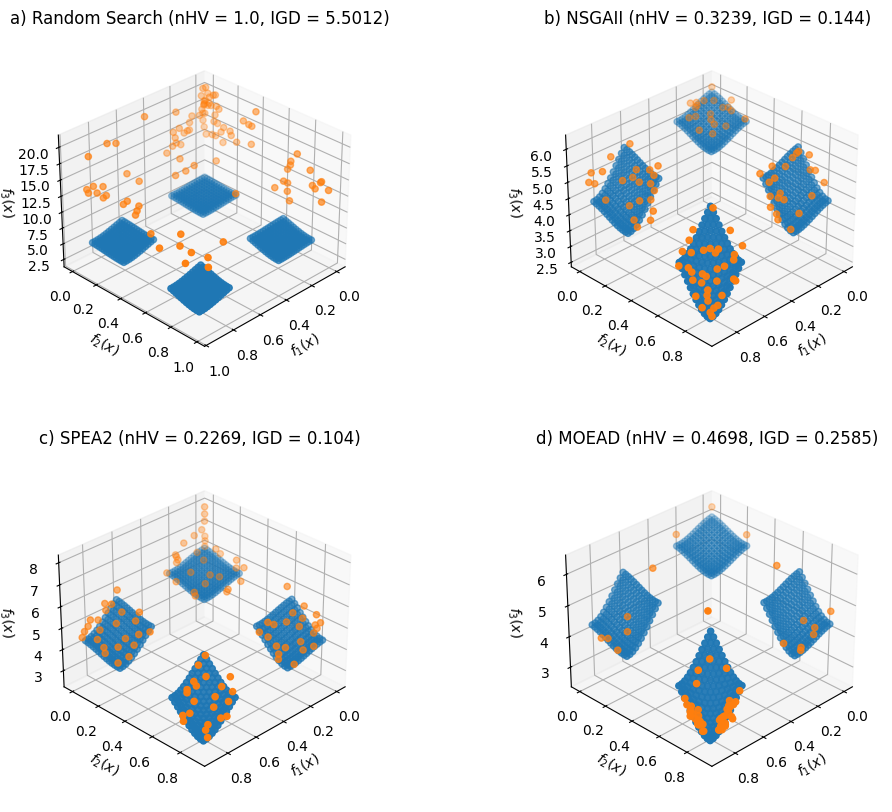

In [28]:
generate_plots_3d(problem.name())